In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import pickle
from scipy.interpolate import interp1d
import imageio.v2 as imageio
from pathlib import Path
import h5py
from scipy.io import savemat
import scipy.integrate as integrate
from skimage import exposure
from skimage import filters
from scipy import stats
from scipy.io import readsav

import torch
import torch.nn as nn
import timm

from plasma_tv.data.file_utils import GetEmission, GetPkl
from plasma_tv.utils.helpers import *

In [4]:
# tempstr = ''
# for file_name in files_temp:
#     temp_name = file_name.stem.split('_')[-1]
#     tempstr += temp_name
#     tempstr += ', '
    
# print(tempstr)

In [30]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# System Identification
# Do this after doing weighted_prediction_ml
tv = GetEmission('../data/raw/all')
files = tv.list_files(True)
files_temp = files.copy()
file_idx = 0
[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = tv.load_all(files[file_idx])
shotn = files[file_idx].stem.split('_')[-1]
# histogram match vid

vid_noisy = noisify(vid)
images_M = vid_noisy.astype(np.float32) / 255.0

target_cdf = np.load('../data/processed/histogram/target_cdf.npy')
bin_edges = np.load('../data/processed/histogram/bin_edges.npy')
vid = match_images_to_histogram(images_M, target_cdf, bin_edges)
value_path = Path('../data/processed/') / 'weight_ml_point'
# tv = GetPkl('../data/raw/12_03_2024')
# files = tv.list_files(True)
# # copy the result over to data_fetching on iris
# print([int(i.stem.split('_')[-1]) for i in files])
# file_idx = 18
# shotn = files[file_idx].stem.split('_')[-1]
# print(f'Shot {shotn}')

0 	 189057
1 	 189061
2 	 189062
3 	 189081
4 	 189088
5 	 189090
6 	 189093
7 	 189094
8 	 189097
9 	 189100
10 	 189101
11 	 189448
12 	 189451
13 	 190109
14 	 190110
15 	 190113
16 	 190114
17 	 190115
18 	 190116
19 	 199166
20 	 199171
21 	 199172
22 	 199351
23 	 199352
24 	 199353
25 	 199354
Extracting sav for shot: 189057


In [31]:
h5_path = '../data/external/toksearch/12_03_2024_bfield.h5'
shot = str(files[file_idx].stem.split('_')[-1])
print(shot)
with h5py.File(h5_path, 'r') as file:
    
    print(file.keys())
    
    for key in file.keys():
        print(file[key].keys())
        break
    
    h5_times = file['times'][:]
    ZXPT1_EFIT01 = file[shot]['ZXPT1_EFIT01'][:]
    RXPT1_EFIT01 = file[shot]['RXPT1_EFIT01'][:]

189057
<KeysViewHDF5 ['189057', '189061', '189062', '189081', '189088', '189090', '189093', '189094', '189097', '189100', '189101', '189448', '189451', '190109', '190110', '190113', '190114', '190115', '190116', '199166', '199171', '199172', '199351', '199352', '199353', '199354', 'spatial_coordinates', 'times']>
<KeysViewHDF5 ['RXPT1_EFIT01', 'ZXPT1_EFIT01', 'gas_sql', 'ip_flat_duration_sql', 't_ip_flat_sql', 'valve_sql']>


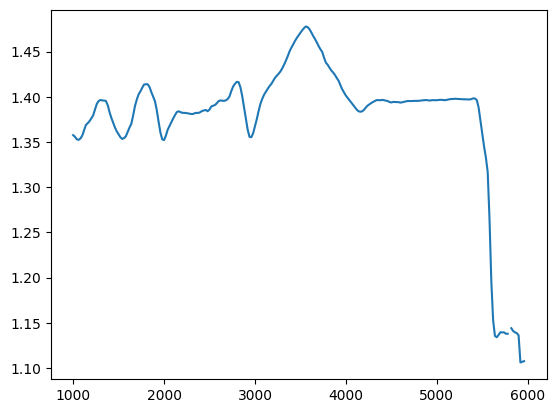

In [32]:
plt.plot(h5_times, RXPT1_EFIT01)

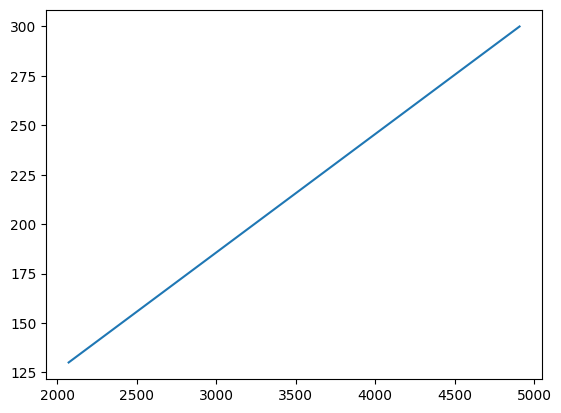

In [33]:
plt.plot(times,frames)

In [34]:
t_min = times[0]
t_max = times[-1]
mask = (h5_times >= t_min) & (h5_times <= t_max)

cropped_times = h5_times[mask]
cropped_data  = RXPT1_EFIT01[mask]

# 2. Create a new time grid with the same number of points as frames
new_time_grid = np.linspace(t_min, t_max, num=len(frames))

# 3. Interpolate the cropped data onto the new time grid
#    np.interp(x, xp, fp) returns interpolations of fp at x, 
#    given xp (cropped_times) and fp (cropped_data).
interpolated_data = np.interp(new_time_grid, cropped_times, cropped_data)

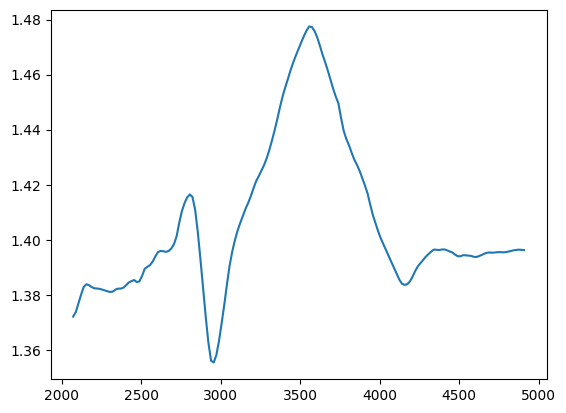

In [35]:
plt.plot(times, interpolated_data)